# Modélisation d'un AE conservant les métriques de distance

In [6]:
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

import wfdb 

# Own modules
from AutoEncoder import AutoEncoder
from SignaGenerator import SignalGenerator
from train import train, plot_loss
from Utils import *


## 4.1 Synthetic signal generation

                    Dataset Generation Parameters
Parameter                 | Value                         
------------------------------------------------------------
Number of Signals         | 1000                          
Polynomial Coefficients   | (-7, 7)                       
Cosine Amplitudes         | (0, 5)                        
Frequencies               | (0.5, 8)                      
Phases                    | (0, 6.283185307179586)        
Number of Points          | 1024                          
Noise Std Dev             | 0.3                           
Sampling Frequency (Fe)   | 1024                          
Polynomial Degree (N_p)   | 3                             
Number of Cosines (N_c)   | 8                             
Normalization             | False                         
ECG                       | 0                             


generating signals: 100%|██████████| 1000/1000 [00:00<00:00, 3514.88it/s]
/tmp/ipykernel_25049/4043042118.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=8)


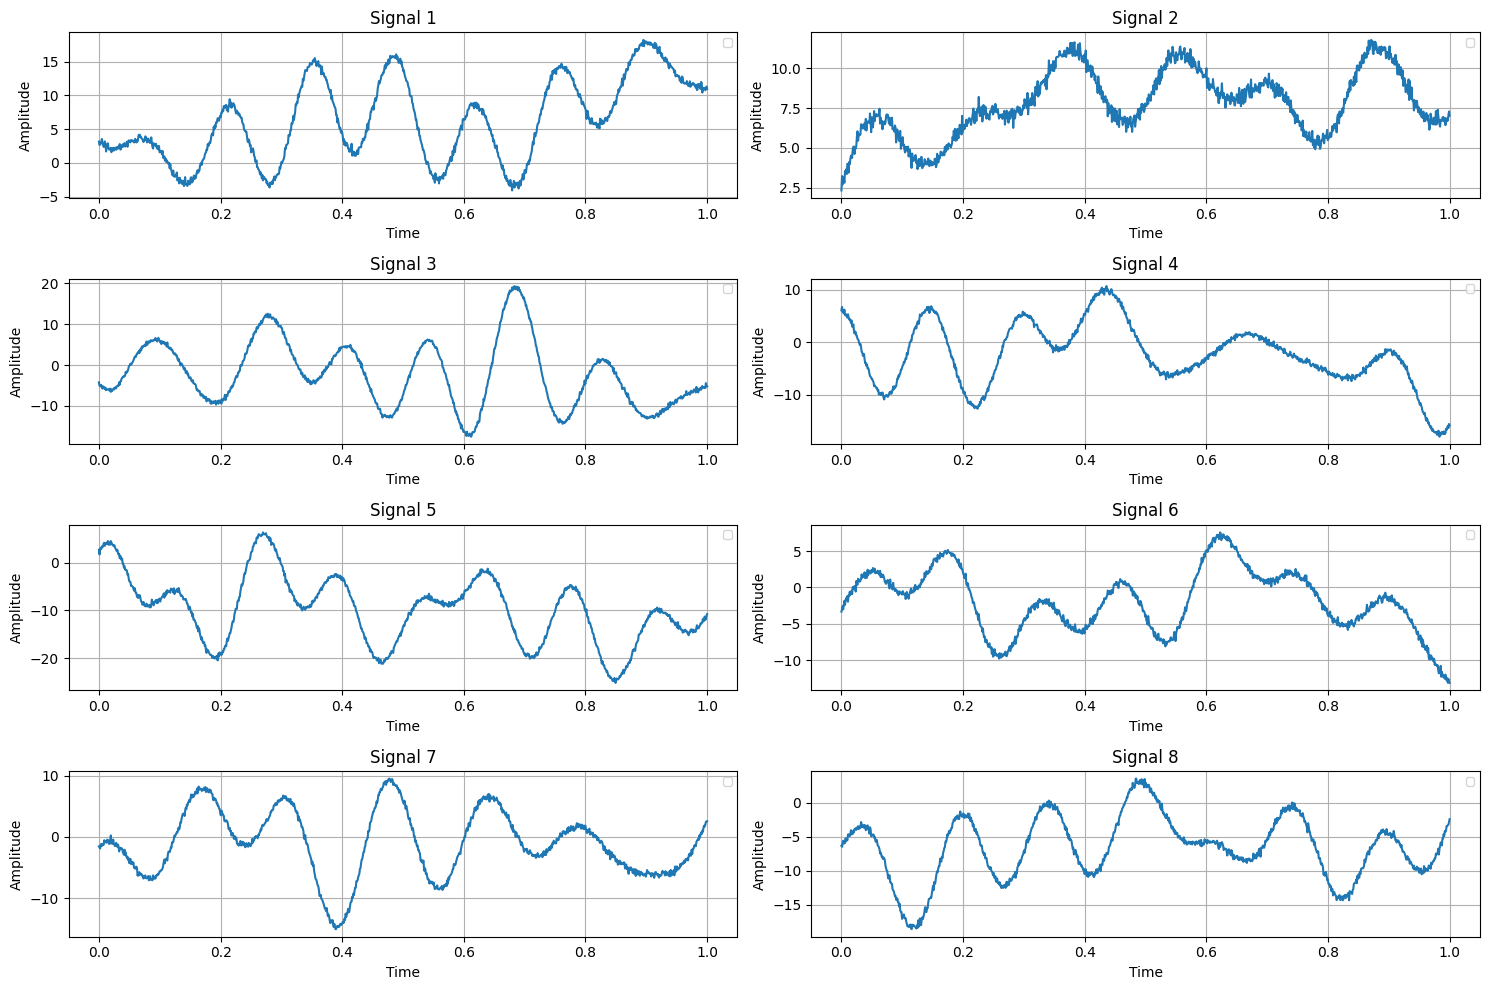

In [7]:
generator = SignalGenerator()

# Parameters of generated signals
A_RANGE = (-7, 7)
B_RANGE = (0, 5)
W_RANGE = (0.5, 8)
PHI_RANGE=(0, 2 * np.pi)
NB_POINTS = 1024
NORMALIZE = False
FE = 1024
NOISE_STD = 0.3
NP = 3
NC = 8

dataset = generator.generate_dataset(num_signals=1000, a_range=A_RANGE, b_range=B_RANGE, w_range=W_RANGE, phi_range=PHI_RANGE, nb_points=NB_POINTS, Fe=FE, N_p=NP, N_c=NC, noise_std=NOISE_STD, normalize=NORMALIZE, verbose=True)
random_indices = random.sample(range(len(dataset)), 8)
selected_signals = [dataset[i] for i in random_indices]

plt.figure(figsize=(15, 10))
for i, (signal, params) in enumerate(selected_signals):
    plt.subplot(4, 2, i + 1)
    plt.plot(generator.time, signal)
    plt.title(f"Signal {i + 1}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend(fontsize=8)
    plt.grid(True)

plt.tight_layout()
plt.show()

In [8]:
A_RANGE = (-7, 7)
B_RANGE = (0, 5)
W_RANGE = (0.5, 8)
PHI_RANGE=(0, 2 * np.pi)
NB_POINTS = 1024
FE = 1024
NOISE_STD = 0.1
NP = 3
NC = 8

full_dataset = generator.generate_dataset(num_signals=20000, a_range=A_RANGE, b_range=B_RANGE, w_range=W_RANGE, phi_range=PHI_RANGE,nb_points=NB_POINTS, Fe=FE, noise_std=NOISE_STD, N_p=NP, N_c=NC, normalize=True, verbose=True)


signals = np.array([item[0] for item in full_dataset])

# Parameters of interest that reflects the distance in the input space
a_param = np.array([item[1]["a"] for item in full_dataset])
w_param = np.array([item[1]["w"] for item in full_dataset])
b_param = np.array([item[1]["b"] for item in full_dataset])
phi_param = np.array([item[1]["phi"] for item in full_dataset])

scaler_a = MinMaxScaler(feature_range=(0, 1))
scaler_w = MinMaxScaler(feature_range=(0, 1))
scaler_b = MinMaxScaler(feature_range=(0, 1))
scaler_phi = MinMaxScaler(feature_range=(0, 1))

a_param = scaler_a.fit_transform(a_param)
w_param = scaler_w.fit_transform(w_param)
b_param = scaler_b.fit_transform(b_param)
phi_param = scaler_phi.fit_transform(phi_param)

params = np.concatenate((a_param, w_param, b_param, phi_param), axis=1)


signals_tensor = torch.tensor(signals, dtype=torch.float32)

params_tensor = torch.tensor(params, dtype=torch.float32)
indexes = torch.arange(len(signals_tensor))
train_tensor_dataset = TensorDataset(signals_tensor, indexes)
train_dataloader = DataLoader(train_tensor_dataset, batch_size=128, shuffle=True)

                    Dataset Generation Parameters
Parameter                 | Value                         
------------------------------------------------------------
Number of Signals         | 20000                         
Polynomial Coefficients   | (-7, 7)                       
Cosine Amplitudes         | (0, 5)                        
Frequencies               | (0.5, 8)                      
Phases                    | (0, 6.283185307179586)        
Number of Points          | 1024                          
Noise Std Dev             | 0.1                           
Sampling Frequency (Fe)   | 1024                          
Polynomial Degree (N_p)   | 3                             
Number of Cosines (N_c)   | 8                             
Normalization             | True                          
ECG                       | 0                             


generating signals: 100%|██████████| 20000/20000 [00:10<00:00, 1836.82it/s]


## Training of the CAE (Convolutionnal Auto Encoder)

In [9]:
CONV=True
INPUT_DIM = signals_tensor.shape[1]
LATENT_DIM = 256
EPOCHS = 40
LEARNING_RATE = 0.001
ALPHA = 1.0
BETA = 3.0

autoencoder = AutoEncoder(input_dim=INPUT_DIM, latent_dim=LATENT_DIM, conv=CONV)

total_loss, reconstruction_loss, distance_loss = train(autoencoder=autoencoder, train_loader=train_dataloader, params_train=params_tensor, alpha=ALPHA, beta=BETA, epochs=EPOCHS, verbose=True)

               Training Parameters
Parameter            | Value               
--------------------------------------------------
Epochs               | 40                  
Learning rate        | 0.001               
Alpha                | 1.0                 
Beta                 | 3.0                 
--------------------------------------------------


Training:   0%|          | 0/40 [00:00<?, ?it/s]/home/marius/envs/main_venv/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training:   2%|▎         | 1/40 [00:22<14:18, 22.02s/it]

Epoch 1/40 | Loss: 0.9705 | Recon: 0.0454 | Dist: 0.3084


Training:   8%|▊         | 3/40 [01:07<13:47, 22.37s/it]

Epoch 3/40 | Loss: 0.2876 | Recon: 0.0034 | Dist: 0.0947


Training:  12%|█▎        | 5/40 [01:50<12:48, 21.95s/it]

Epoch 5/40 | Loss: 0.2630 | Recon: 0.0023 | Dist: 0.0869


Training:  18%|█▊        | 7/40 [02:32<11:48, 21.46s/it]

Epoch 7/40 | Loss: 0.2455 | Recon: 0.0021 | Dist: 0.0811


Training:  22%|██▎       | 9/40 [03:15<11:00, 21.30s/it]

Epoch 9/40 | Loss: 0.2326 | Recon: 0.0018 | Dist: 0.0769


Training:  28%|██▊       | 11/40 [03:57<10:17, 21.30s/it]

Epoch 11/40 | Loss: 0.2240 | Recon: 0.0016 | Dist: 0.0741


Training:  32%|███▎      | 13/40 [04:40<09:34, 21.27s/it]

Epoch 13/40 | Loss: 0.2171 | Recon: 0.0014 | Dist: 0.0719


Training:  38%|███▊      | 15/40 [05:22<08:51, 21.25s/it]

Epoch 15/40 | Loss: 0.2102 | Recon: 0.0016 | Dist: 0.0695


Training:  42%|████▎     | 17/40 [06:05<08:08, 21.23s/it]

Epoch 17/40 | Loss: 0.2034 | Recon: 0.0017 | Dist: 0.0672


Training:  48%|████▊     | 19/40 [06:48<07:31, 21.50s/it]

Epoch 19/40 | Loss: 0.1949 | Recon: 0.0017 | Dist: 0.0644


Training:  52%|█████▎    | 21/40 [07:31<06:47, 21.43s/it]

Epoch 21/40 | Loss: 0.1879 | Recon: 0.0020 | Dist: 0.0619


Training:  57%|█████▊    | 23/40 [08:14<06:03, 21.38s/it]

Epoch 23/40 | Loss: 0.1818 | Recon: 0.0017 | Dist: 0.0600


Training:  62%|██████▎   | 25/40 [08:56<05:19, 21.30s/it]

Epoch 25/40 | Loss: 0.1766 | Recon: 0.0016 | Dist: 0.0583


Training:  68%|██████▊   | 27/40 [09:39<04:37, 21.32s/it]

Epoch 27/40 | Loss: 0.1714 | Recon: 0.0014 | Dist: 0.0567


Training:  72%|███████▎  | 29/40 [10:21<03:54, 21.35s/it]

Epoch 29/40 | Loss: 0.1703 | Recon: 0.0014 | Dist: 0.0563


Training:  78%|███████▊  | 31/40 [11:04<03:12, 21.34s/it]

Epoch 31/40 | Loss: 0.1666 | Recon: 0.0014 | Dist: 0.0551


Training:  82%|████████▎ | 33/40 [11:47<02:28, 21.27s/it]

Epoch 33/40 | Loss: 0.1657 | Recon: 0.0013 | Dist: 0.0548


Training:  88%|████████▊ | 35/40 [12:29<01:46, 21.25s/it]

Epoch 35/40 | Loss: 0.1653 | Recon: 0.0013 | Dist: 0.0547


Training:  92%|█████████▎| 37/40 [13:11<01:03, 21.24s/it]

Epoch 37/40 | Loss: 0.1636 | Recon: 0.0012 | Dist: 0.0541


Training:  98%|█████████▊| 39/40 [13:54<00:21, 21.22s/it]

Epoch 39/40 | Loss: 0.1635 | Recon: 0.0011 | Dist: 0.0541


Training: 100%|██████████| 40/40 [14:15<00:00, 21.39s/it]

Epoch 40/40 | Loss: 0.1640 | Recon: 0.0012 | Dist: 0.0543


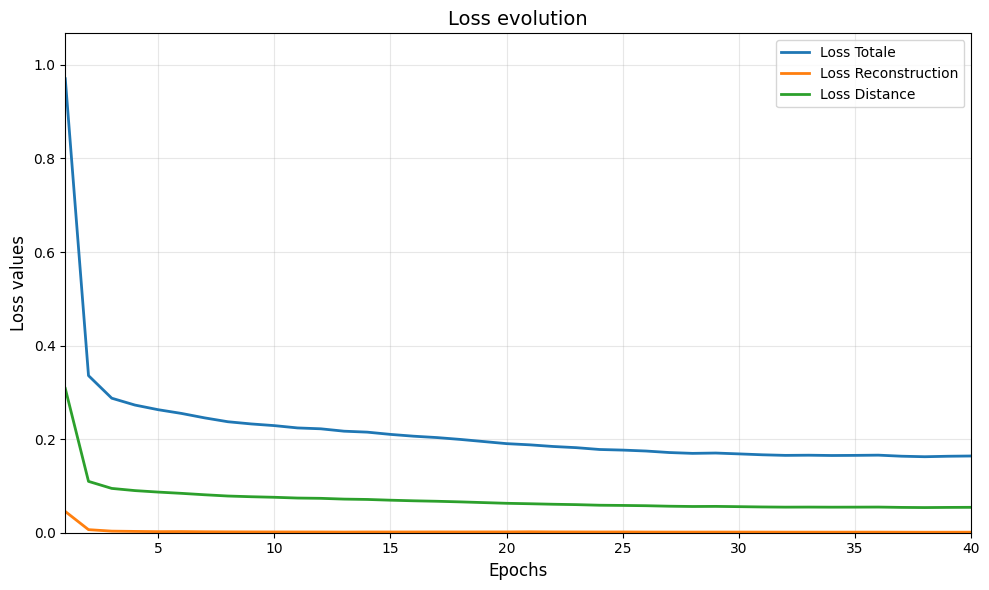

In [10]:
plot_loss(total_loss, reconstruction_loss, distance_loss)

## 6.1 Signal distance measurement

/tmp/ipykernel_25049/3841798759.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  test_signals = torch.tensor([sin1, sin2, close1, close2, far1, far2], dtype=torch.float32)


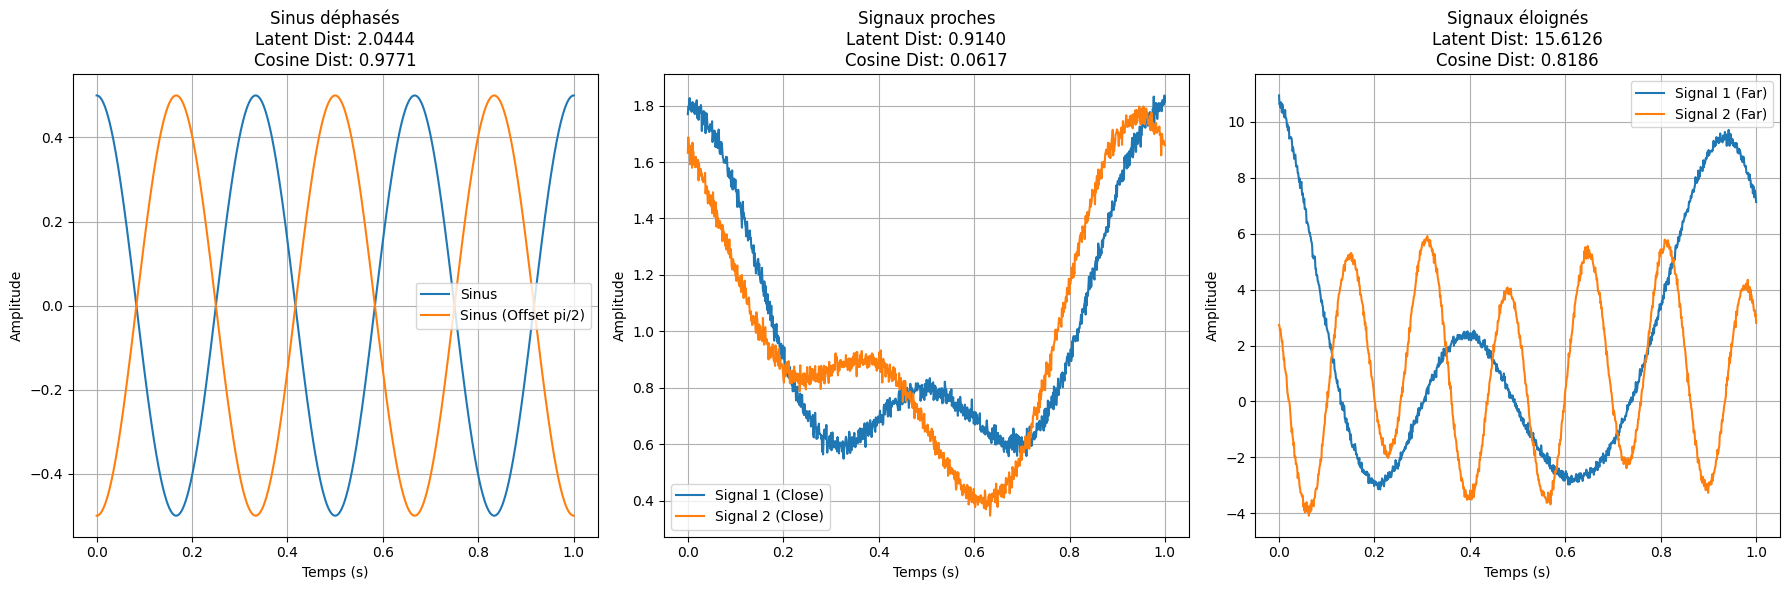

In [ ]:
time = np.linspace(0, INPUT_DIM/FE, FE)
# No normalisation amplify the mesure of the distance
NORMALIZE = False
sin1 = generator.generate_signal(a=[0], b=[0.5], w=[3], phi=[0], nb_points=NB_POINTS, Fe=FE, noise_std=0, normalize=NORMALIZE)
sin2 = generator.generate_signal(a=[0], b=[0.5], w=[3], phi=[np.pi], nb_points=NB_POINTS, Fe=FE, noise_std=0, normalize=NORMALIZE)
close1 = generator.generate_signal(a=[1.0], b=[0.5, 0.3], w=[1.0, 2.0], phi=[0.0, 0.0], nb_points=NB_POINTS, Fe=FE, noise_std=0.02, normalize=NORMALIZE)
close2 = generator.generate_signal(a=[1.0], b=[0.5, 0.3], w=[1.0, 2.0], phi=[0.0, 1], nb_points=NB_POINTS, Fe=FE, noise_std=0.02, normalize=NORMALIZE)
far1 = generator.generate_signal(a=[2, 1, -2], b=[1.0, 4.5, 3.5, 1, 1], w=[0.5, 1, 2, 2.2, 3], phi=[0.0, 0.5, 1.0, 0, 0], nb_points=NB_POINTS, Fe=FE, noise_std=NOISE_STD, normalize=NORMALIZE)
far2 = generator.generate_signal(a=[1.0], b=[1, 0.2, 4, 0, 0], w=[2.0, 3.0, 6.0, 6.5, 7.0], phi=[np.pi, np.pi / 2, np.pi / 4, 0, 0], nb_points=NB_POINTS, Fe=FE, noise_std=NOISE_STD, normalize=NORMALIZE)

test_signals = torch.tensor([sin1, sin2, close1, close2, far1, far2], dtype=torch.float32)

autoencoder.eval()
with torch.no_grad():
    _, test_latent = autoencoder(test_signals)

distance_sin_latent = torch.norm(test_latent[0] - test_latent[1], p=2).item()
distance_close_latent = torch.norm(test_latent[2] - test_latent[3], p=2).item()
distance_far_latent = torch.norm(test_latent[4] - test_latent[5], p=2).item()

distance_sin_cosine = cosine_distance(test_latent[0], test_latent[1]).item()
distance_close_cosine = cosine_distance(test_latent[2], test_latent[3]).item()
distance_far_cosine = cosine_distance(test_latent[4], test_latent[5]).item()


plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(time, sin1, label="Sinus")
plt.plot(time, sin2, label="Sinus (Offset pi/2)")
plt.title(f"Sinus déphasés\nLatent Dist: {distance_sin_latent:.4f}\nCosine Dist: {distance_sin_cosine:.4f}")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(time, close1, label="Signal 1 (Close)")
plt.plot(time, close2, label="Signal 2 (Close)")
plt.title(f"Signaux proches\nLatent Dist: {distance_close_latent:.4f}\nCosine Dist: {distance_close_cosine:.4f}")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(time, far1, label="Signal 1 (Far)")
plt.plot(time, far2, label="Signal 2 (Far)")
plt.title(f"Signaux éloignés\nLatent Dist: {distance_far_latent:.4f}\nCosine Dist: {distance_far_cosine:.4f}")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

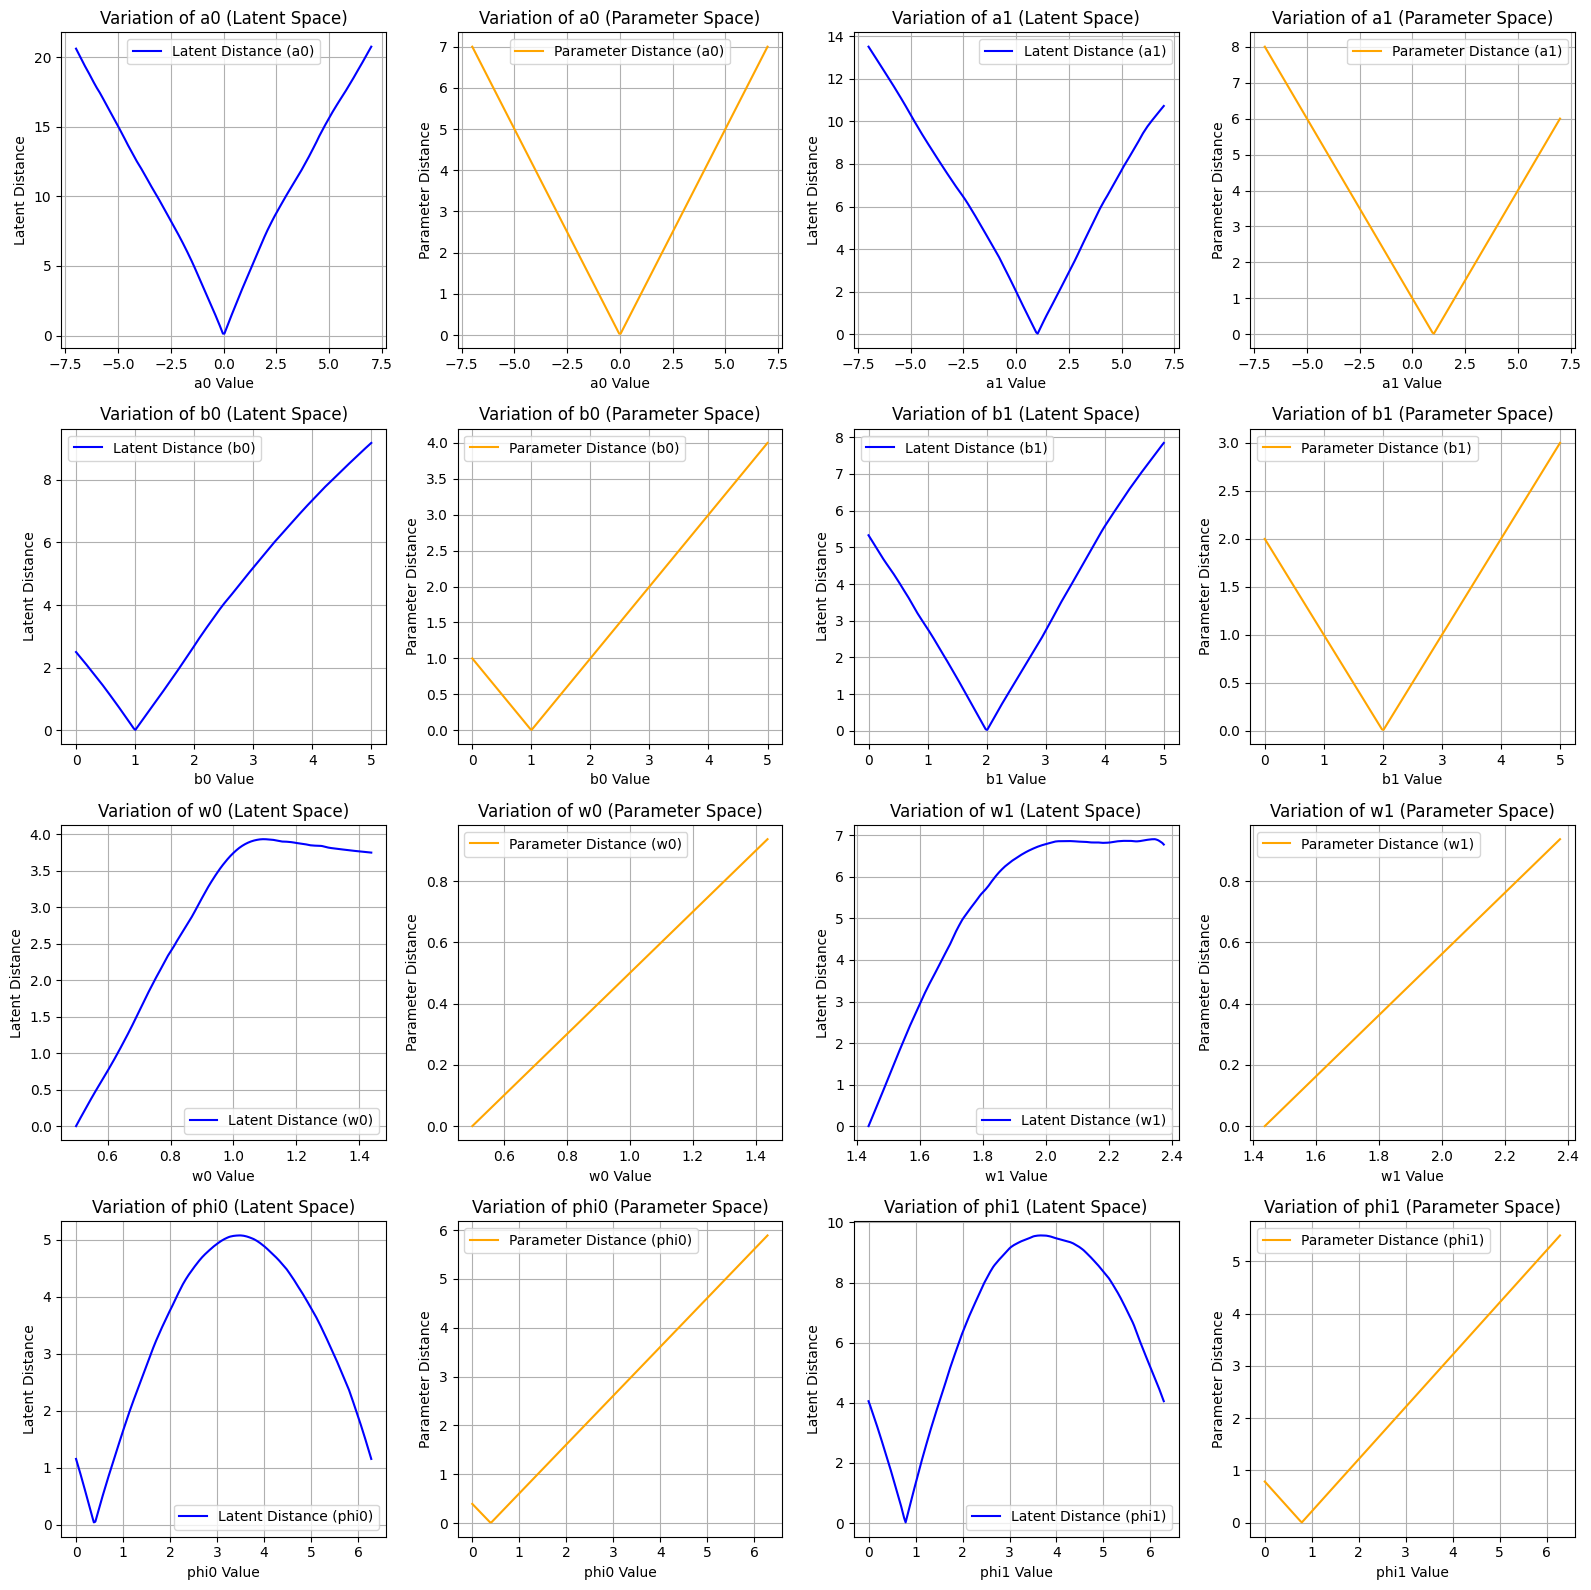

In [12]:
NOISE_STD = 0.0
# The trajectories of latent vectors are piecewise linear when frequencies are varied. To do this, we generate frequency ranges
# and vary cosine frequencies linearly within each range

ranges = [np.linspace(W_RANGE[0] + i * (W_RANGE[1] - W_RANGE[0]) / NC,
                       W_RANGE[0] + (i + 1) * (W_RANGE[1] - W_RANGE[0]) / NC, 200)
                        for i in range(NC)]

a_fixed = [0, 1]  # Polynomial coefficients
b_fixed = [1, 2, 3, 4, 3, 2, 1, 1]  # Cosine amplitudes
w_fixed = [float(range[0]) for range in ranges]  # Cosine frequencies
phi_fixed = [np.pi / 8, np.pi / 4, np.pi / 3, np.pi, np.pi / 3, np.pi / 3, np.pi / 2, np.pi] # Cosine phases

param_ranges = {
    "a0": np.linspace(A_RANGE[0], A_RANGE[1], 200),
    "a1": np.linspace(A_RANGE[0], A_RANGE[1], 200),
    "b0": np.linspace(B_RANGE[0], B_RANGE[1], 200),
    "b1": np.linspace(B_RANGE[0], B_RANGE[1], 200),
    "b2": np.linspace(B_RANGE[0], B_RANGE[1], 200),
    "b3": np.linspace(B_RANGE[0], B_RANGE[1], 200),
    "w0": ranges[0],
    "w1": ranges[1],
    "w2": ranges[2],
    "w3": ranges[3],
    "phi0": np.linspace(0, 2 * np.pi, 200),
    "phi1": np.linspace(0, 2 * np.pi, 200),
    "phi2": np.linspace(0, 2 * np.pi, 200),
    "phi3": np.linspace(0, 2 * np.pi, 200),
}

selected_params = ["a0", "a1", "b0", "b1", "w0", "w1", "phi0", "phi1"]
param_groups = [
    ["a0", "a1"], 
    ["b0", "b1"], 
    ["w0", "w1"], 
    ["phi0", "phi1"]
]

latent_distances, param_distances = compute_distances(generator, autoencoder, a_fixed, b_fixed, w_fixed, phi_fixed, param_ranges, nb_points=NB_POINTS, Fe=FE, noise_std=NOISE_STD, normalize=False)
plot_variations(latent_distances, param_distances, param_ranges, selected_params, param_groups)

## 6.2 Signal reconstruction

generating signals: 100%|██████████| 1000/1000 [00:00<00:00, 1902.37it/s]


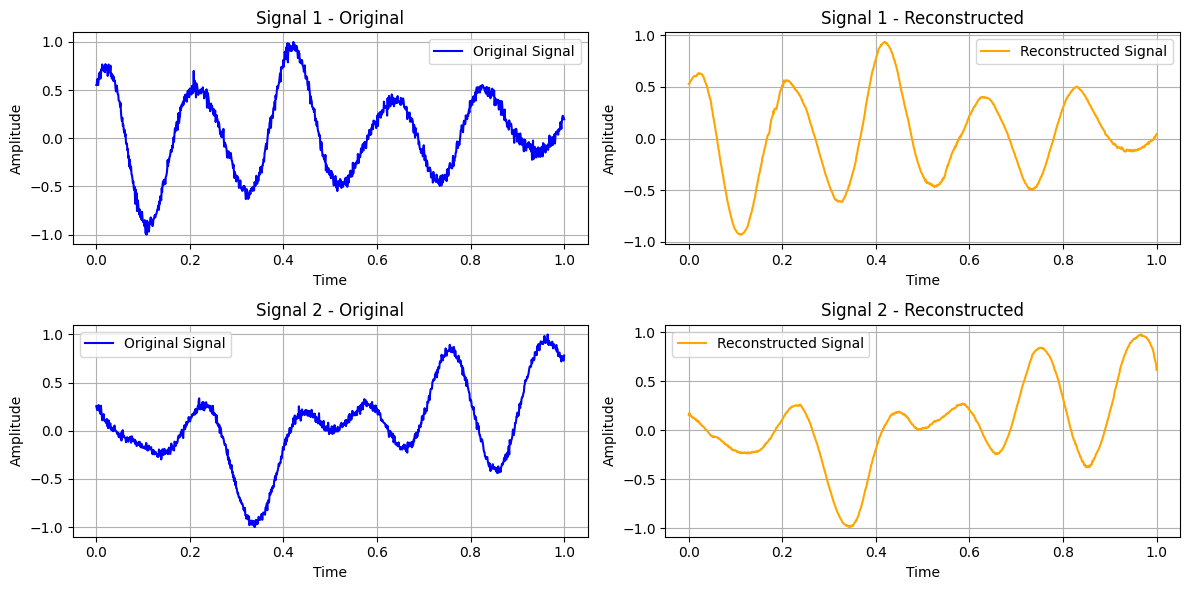

In [14]:
time = np.linspace(0, NB_POINTS/FE, NB_POINTS)
NOISE_STD = 0.3

dataset = generator.generate_dataset(
    num_signals=1000, a_range=A_RANGE, b_range=B_RANGE, w_range=W_RANGE, phi_range=PHI_RANGE, N_p=NP, N_c=NC, nb_points=NB_POINTS, Fe=FE, noise_std=NOISE_STD, normalize=True
)
reconstructed_signals = compute_reconstructed_signals(dataset, autoencoder)

plt.figure(figsize=(12, 6))

for i in range(2):

    plt.subplot(2, 2, 2 * i + 1)
    plt.plot(time, dataset[i][0], label="Original Signal", color="blue")
    plt.title(f"Signal {i + 1} - Original")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 2 * i + 2)
    plt.plot(time, reconstructed_signals[i], label="Reconstructed Signal", color="orange")
    plt.title(f"Signal {i + 1} - Reconstructed")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

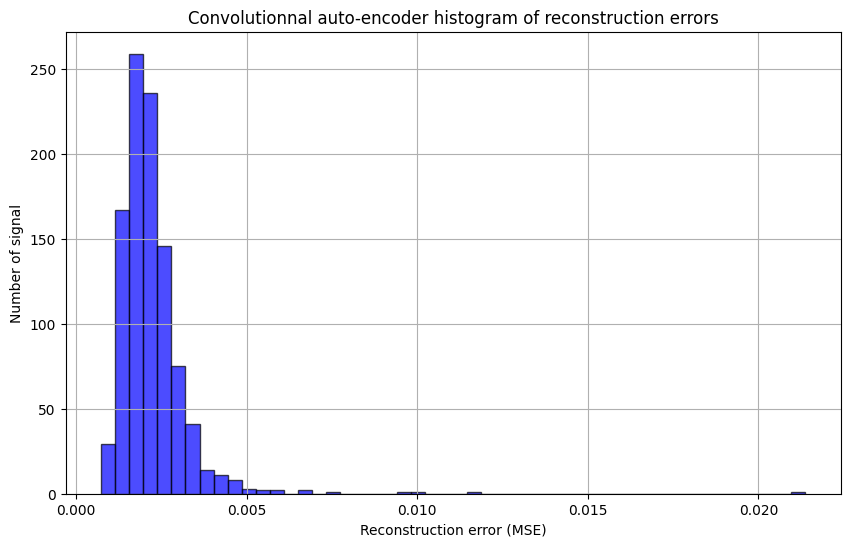

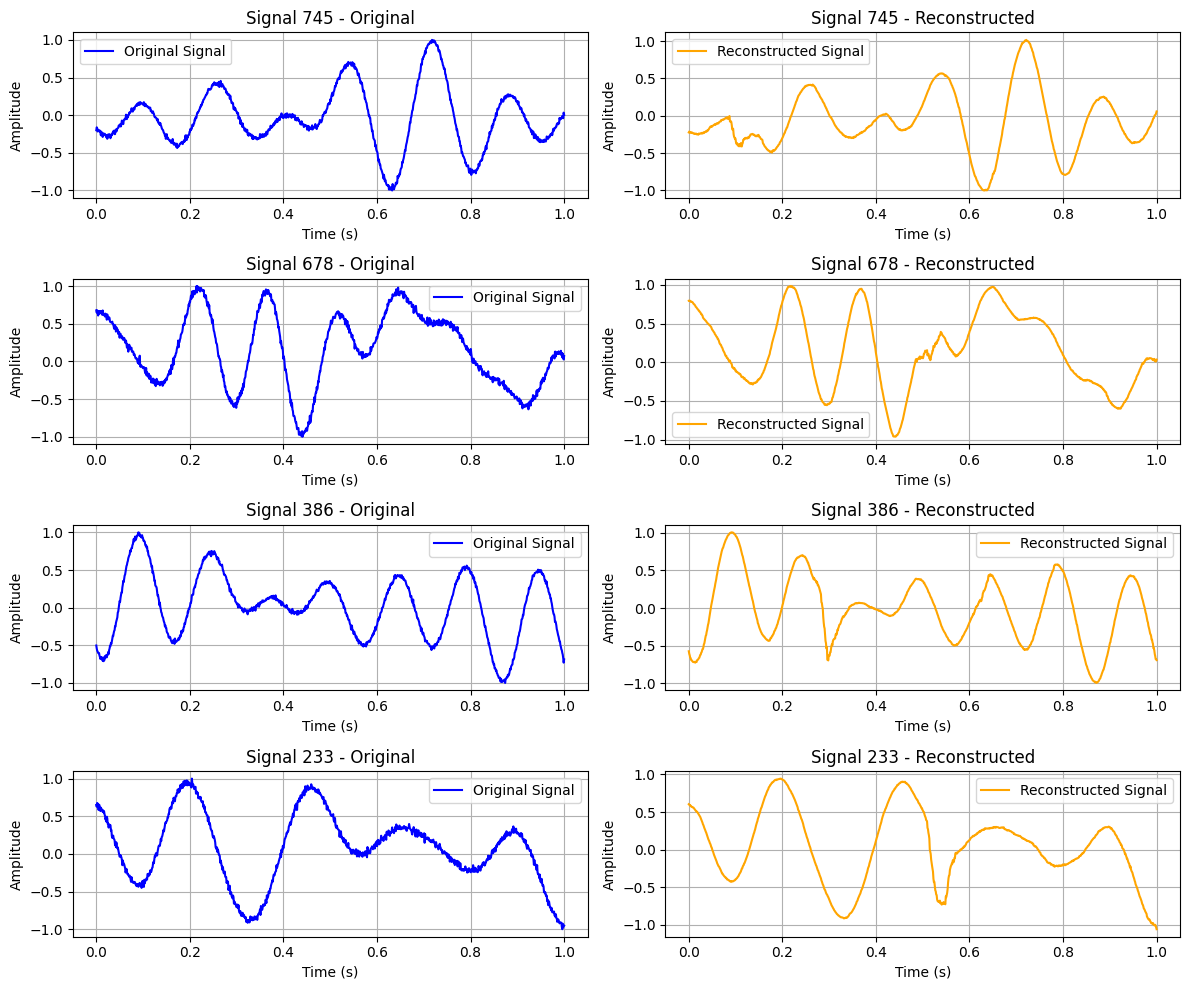

In [15]:
signals = [item[0] for item in dataset]


errors = np.mean((signals - reconstructed_signals) ** 2, axis=1)

plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, color="blue", alpha=0.7, edgecolor="black")
plt.title("Convolutionnal auto-encoder histogram of reconstruction errors")
plt.xlabel("Reconstruction error (MSE)")
plt.ylabel("Number of signal")
plt.grid(True)
plt.show()

worst_indices = np.argsort(errors)[-4:]

plt.figure(figsize=(12, 10))
for i, idx in enumerate(worst_indices):
    plt.subplot(4, 2, 2 * i + 1)
    plt.plot(time, signals[idx], label="Original Signal", color="blue")
    plt.title(f"Signal {idx + 1} - Original")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)

    plt.subplot(4, 2, 2 * i + 2)
    plt.plot(time, reconstructed_signals[idx], label="Reconstructed Signal", color="orange")
    plt.title(f"Signal {idx + 1} - Reconstructed")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


Here we plot the worst reconstruction signals

## 6.3 Parameter trajector in latent space 

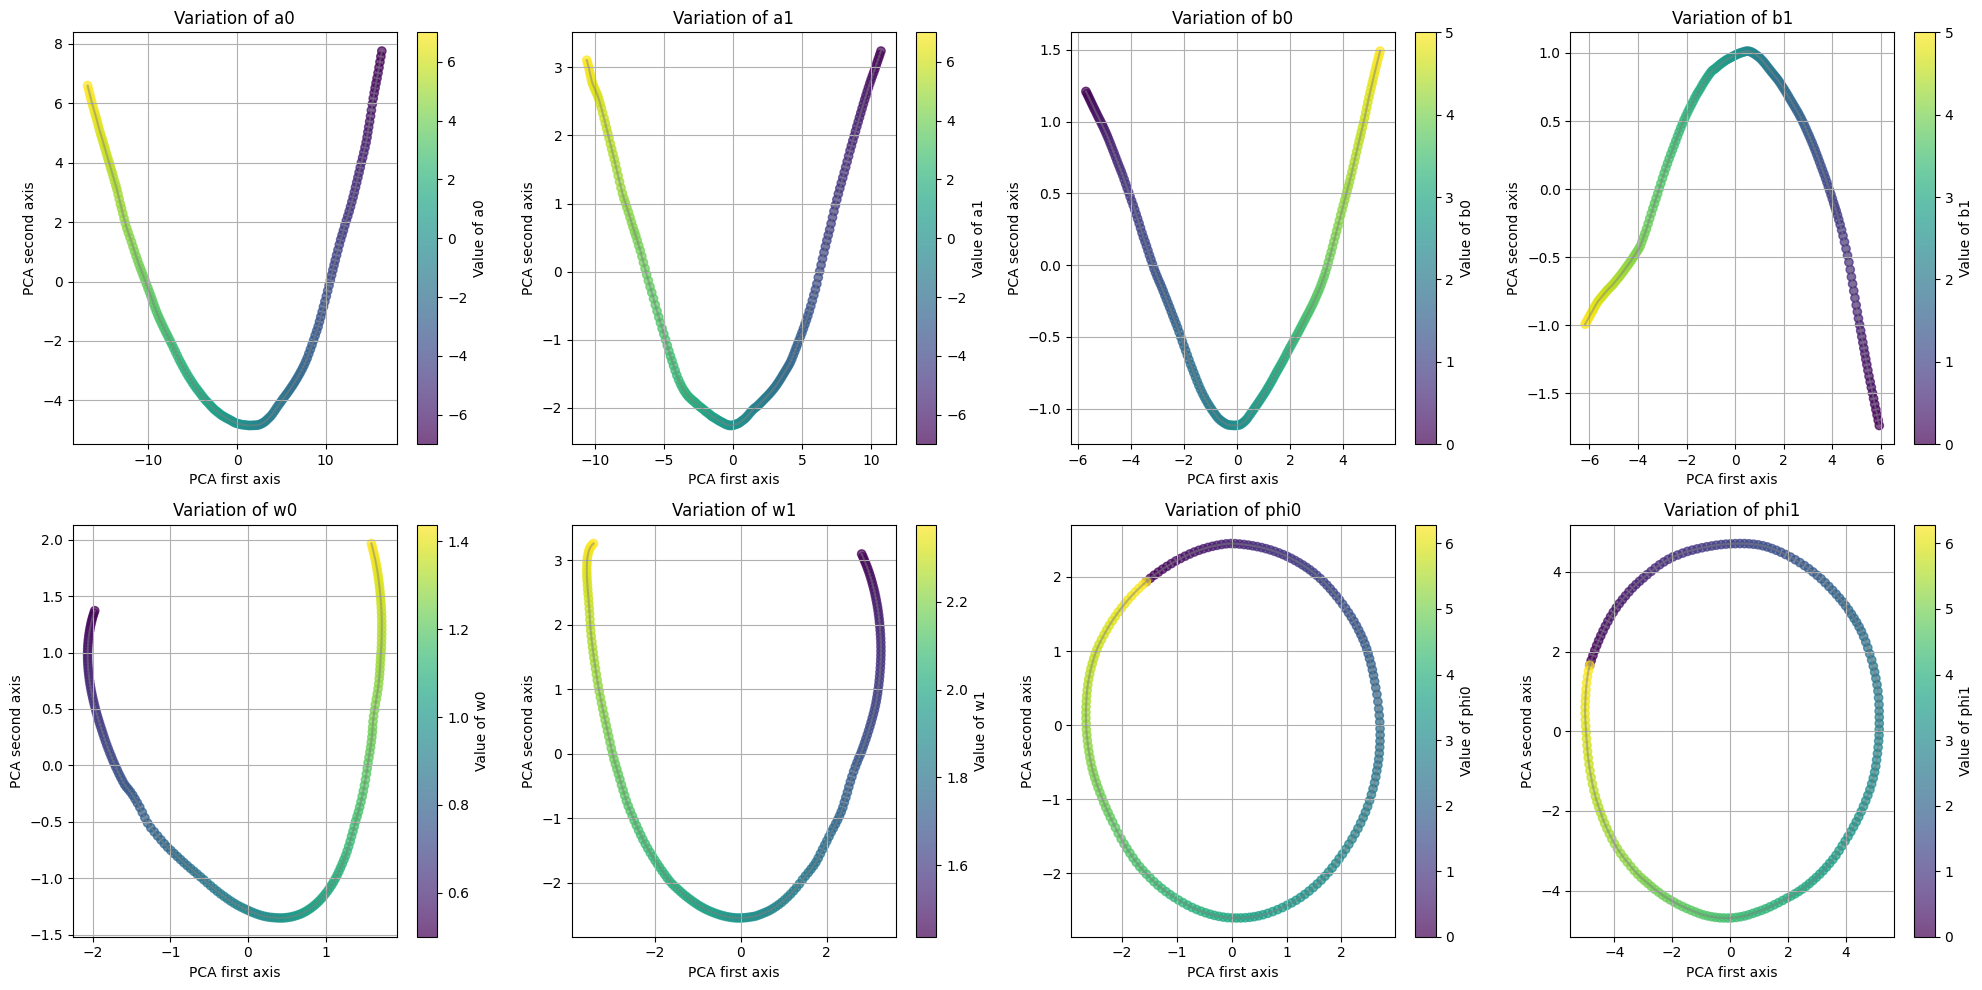

In [16]:
NOISE_STD = 0.0

latent_vectors_dict = get_latent_vectors_variations(generator, autoencoder, a_fixed, b_fixed, w_fixed, phi_fixed, param_ranges, nb_points=NB_POINTS, Fe=FE, noise_std=NOISE_STD, normalize=False)

pca = PCA(n_components=2)

selected_params = ["a0", "a1", "b0", "b1", "w0", "w1", "phi0", "phi1"]

filtered_latent_vectors = {key: latent_vectors_dict[key] for key in selected_params if key in latent_vectors_dict}

num_params = len(filtered_latent_vectors)
num_cols = 4  
num_rows = (num_params + num_cols - 1) // num_cols  
plt.figure(figsize=(20, 5 * num_rows))

for idx, (param_name, latent) in enumerate(filtered_latent_vectors.items()):

    if latent.shape[1] > 2:
        latent_2d = pca.fit_transform(latent)
    else:
        latent_2d = latent

    plt.subplot(num_rows, num_cols, idx + 1)
    plt.scatter(
        latent_2d[:, 0],
        latent_2d[:, 1],
        c=param_ranges[param_name],  
        cmap="viridis",
        alpha=0.7,
    )
    plt.colorbar(label=f"Value of {param_name}")
    plt.plot(latent_2d[:, 0], latent_2d[:, 1], c="gray", alpha=0.5)  
    plt.title(f"Variation of {param_name}")
    plt.xlabel("PCA first axis")
    plt.ylabel("PCA second axis")
    plt.grid(True)

plt.tight_layout()
plt.show()

## 6.4 Cluster Visualization in latent space

Latent vectors encoder: 100%|██████████| 1000/1000 [00:01<00:00, 709.11it/s]


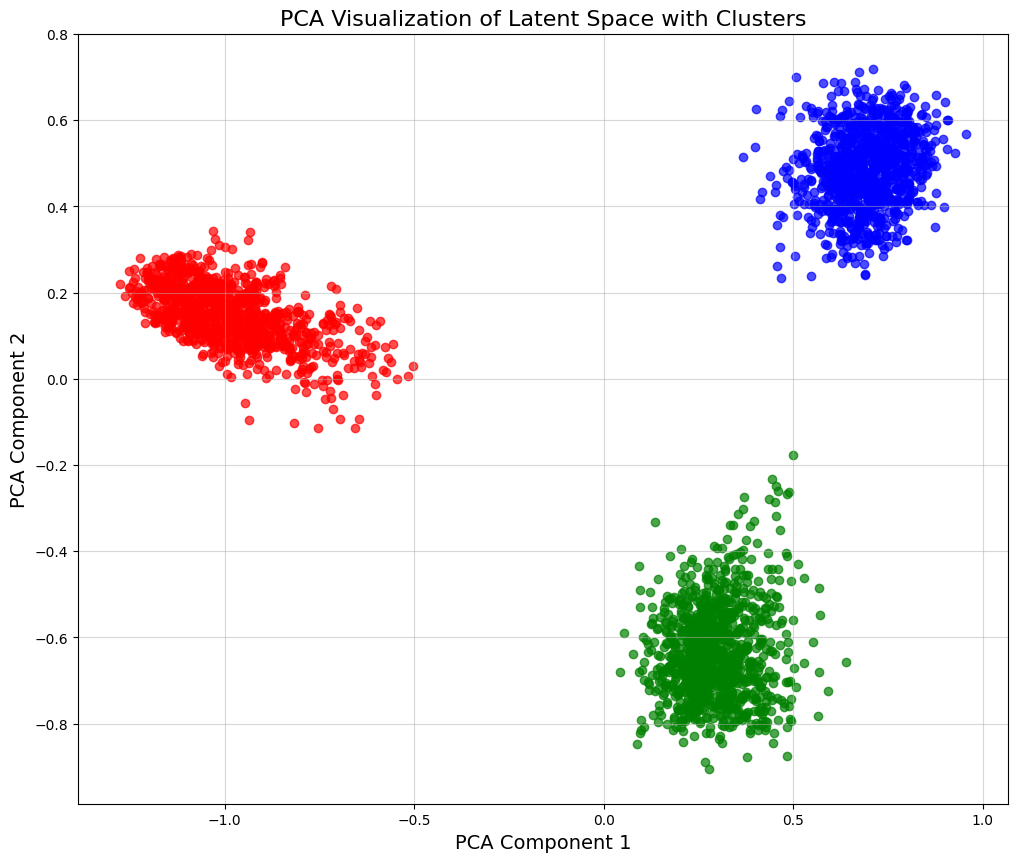

In [18]:
cluster_params = [
    {"a_range": (-7, -4), "b_range": (0, 1), "w_range": (0.5, 2), "phi_range": (0, 1)},  # Cluster 1
    {"a_range": (-3, 3), "b_range": (2, 3), "w_range": (3, 5), "phi_range": (2, 3)},    # Cluster 2
    {"a_range": (4, 7), "b_range": (4, 5), "w_range": (5, 7), "phi_range": (4, 6)}     # Cluster 3
]

latent_vectors = []
labels = []  
NORMALIZE = True

for cluster_idx, params in enumerate(cluster_params):
    dataset = generator.generate_dataset(
        num_signals=1000, 
        a_range=params["a_range"],
        b_range=params["b_range"],
        w_range=params["w_range"],
        phi_range=params["phi_range"],
        N_c=NC,
        N_p=NP,
        nb_points=NB_POINTS,
        Fe=FE,
        noise_std=NOISE_STD,
        normalize=NORMALIZE
    )

    latent_cluster = compute_latent_vectors(dataset, autoencoder)
    latent_vectors.extend(latent_cluster)
    labels.extend([cluster_idx] * len(latent_cluster))

latent_vectors = np.array(latent_vectors)
labels = np.array(labels)


pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_vectors)

plt.figure(figsize=(12, 10))
colors = ["red", "blue", "green"]

for cluster_idx in range(len(cluster_params)):
    cluster_points = latent_2d[labels == cluster_idx]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], alpha=0.7, label=f"Cluster {cluster_idx + 1}", color=colors[cluster_idx])

plt.title("PCA Visualization of Latent Space with Clusters", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=14)
plt.ylabel("PCA Component 2", fontsize=14)
plt.grid(True, alpha=0.5)

plt.show()



## 6.5 Isotropy and properties of latent space

Latent vectors encoder: 100%|██████████| 10000/10000 [00:12<00:00, 788.97it/s]


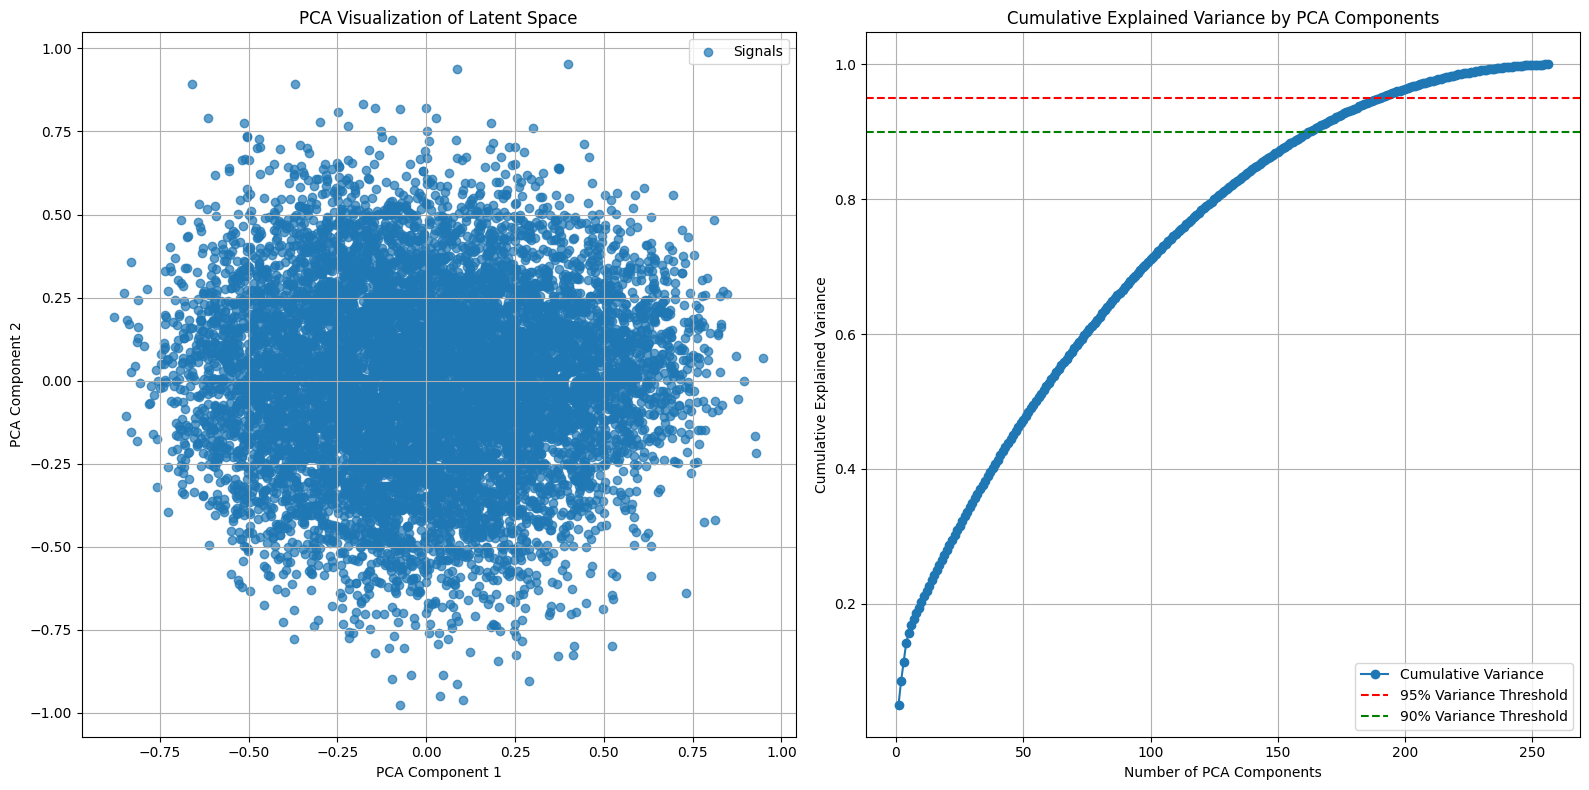

In [19]:
dataset = generator.generate_dataset(num_signals=10000, a_range=A_RANGE, b_range=B_RANGE, w_range=W_RANGE, phi_range=PHI_RANGE, N_c=NC, N_p=NP, nb_points=NB_POINTS, Fe=FE, noise_std=NOISE_STD, normalize=True)
latent_vectors = compute_latent_vectors(dataset, autoencoder)
plot_pca(latent_vectors)

generating signals: 100%|██████████| 1000/1000 [00:00<00:00, 1860.77it/s]


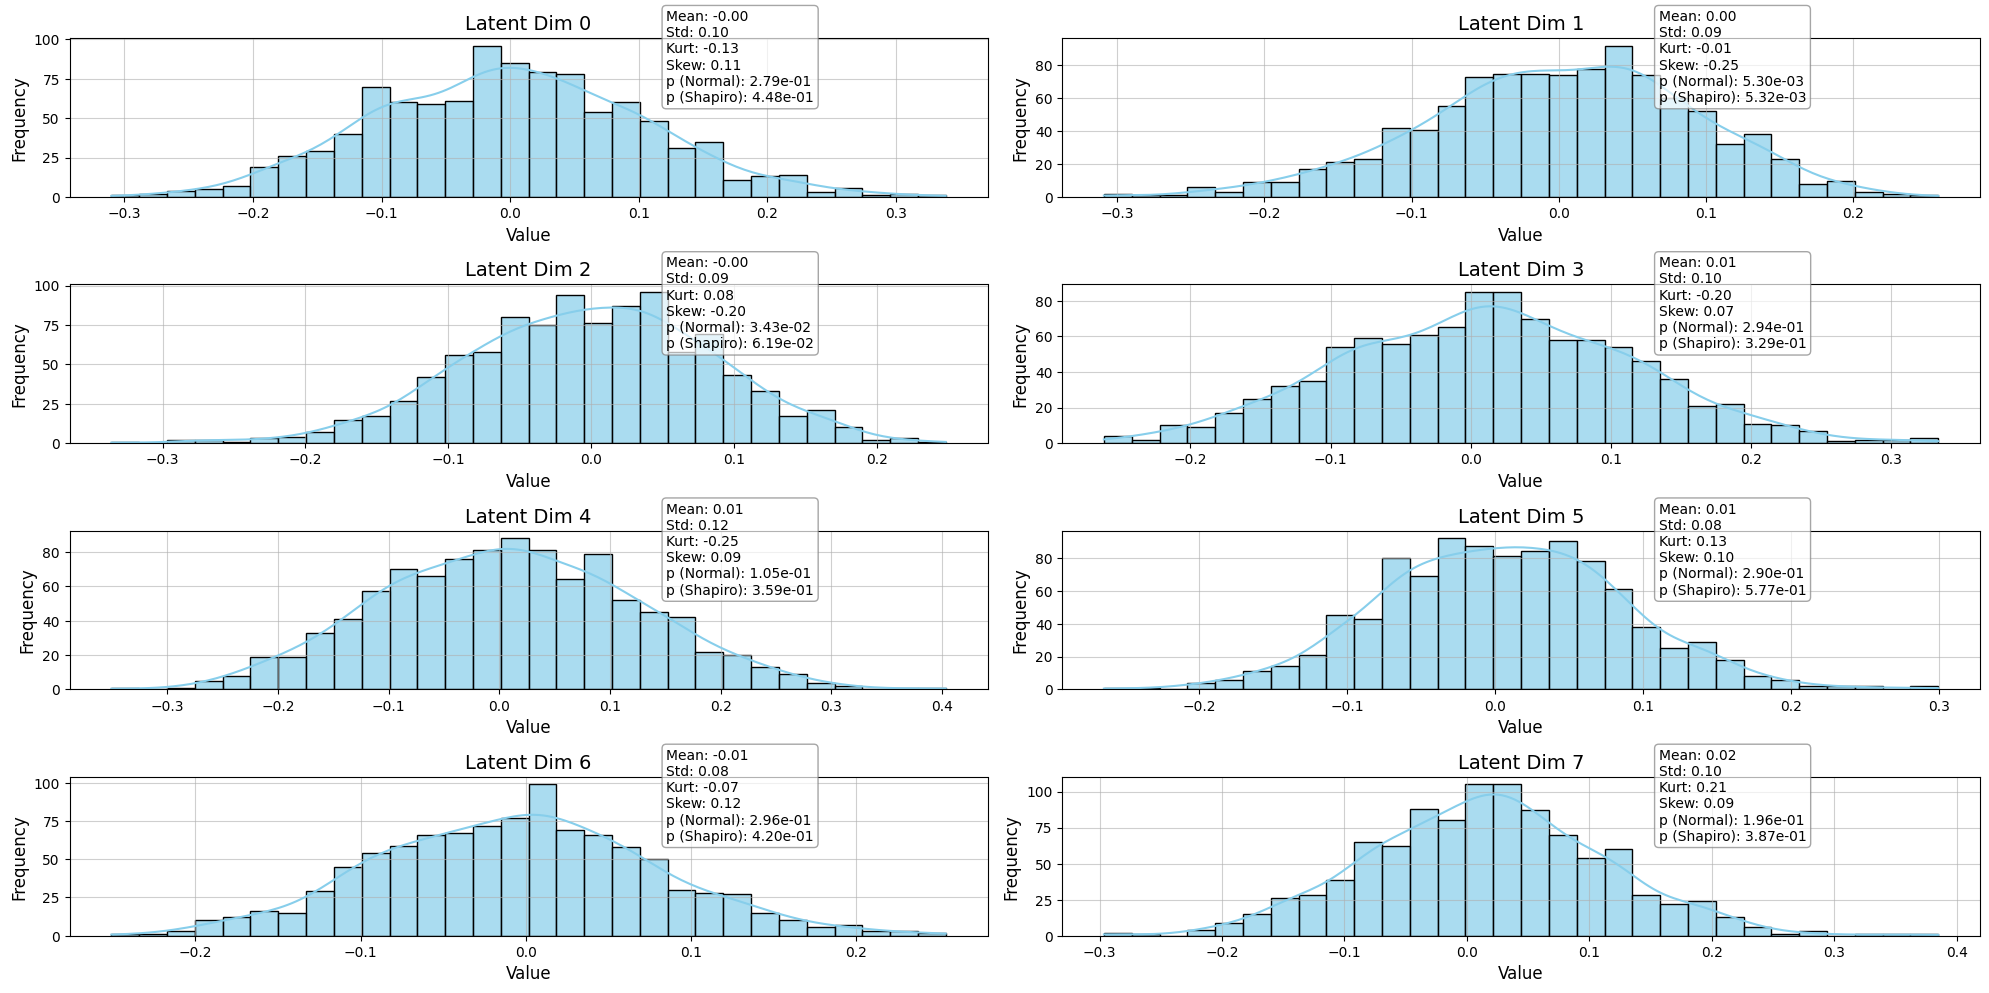

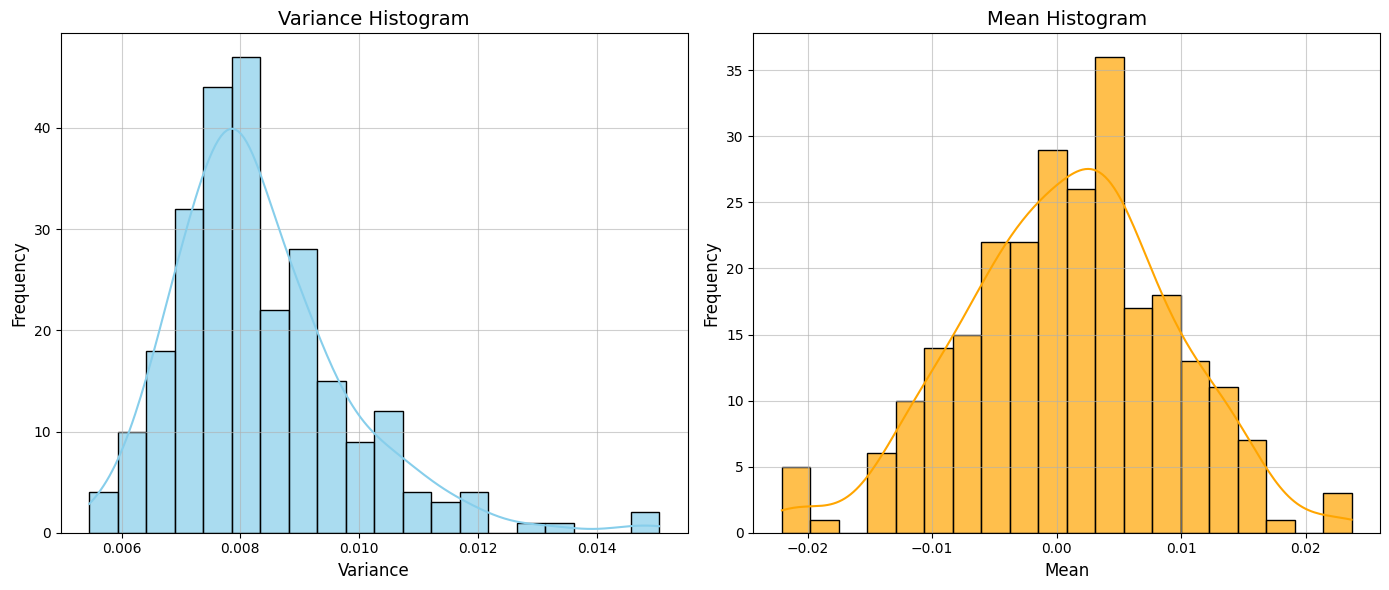

In [20]:
signals = generator.generate_dataset(num_signals=1000, a_range=A_RANGE, b_range=B_RANGE, w_range=W_RANGE, phi_range=PHI_RANGE, N_p=NP, N_c=NC, nb_points=NB_POINTS, Fe=FE, noise_std=NOISE_STD, normalize=True)

signals = np.array([item[0] for item in signals])
signals_tensor = torch.tensor(signals, dtype=torch.float32)

stats = analyze_latent_distribution(autoencoder, signals_tensor, n_bins=30)
plot_latent_variance_mean(autoencoder, signals_tensor)

## 7 ECG signals experiment

## 7.1 ECG signal dataset

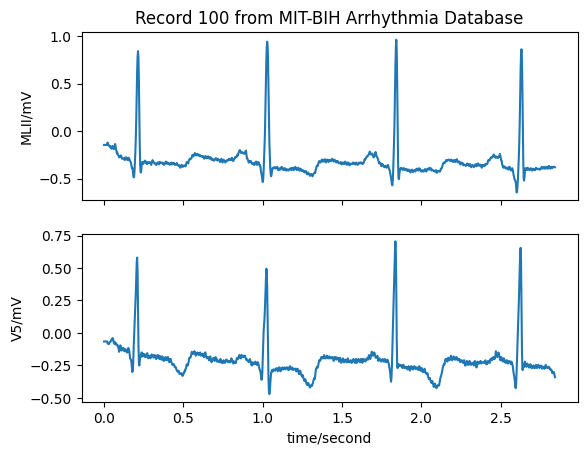

In [49]:
# Make sure you've downloaded the MIT-BIH Arrhythmia Database
# https://physionet.org/content/mitdb/1.0.0/

record = wfdb.rdrecord('../dataset/mitdb/100', sampto=1024)
wfdb.plot_wfdb(record=record, title='Record 100 from MIT-BIH Arrhythmia Database')

In [65]:
ecg_dataset = generator.generate_dataset(ecg=True, n_param=20, nb_points=NB_POINTS)

signals = np.array([item[0] for item in ecg_dataset])
a_param = np.array([item[1]["a"] for item in ecg_dataset])
w_param = np.array([item[1]["w"] for item in ecg_dataset])
phi_param = np.array([item[1]["phi"] for item in ecg_dataset])

scaler_a = MinMaxScaler(feature_range=(0, 1))
scaler_w = MinMaxScaler(feature_range=(0, 1))
scaler_phi = MinMaxScaler(feature_range=(0, 1))

a_param = scaler_a.fit_transform(a_param)
w_param = scaler_w.fit_transform(w_param)
phi_param = scaler_phi.fit_transform(phi_param)

params = np.concatenate((a_param, w_param, phi_param), axis=1)

signals_tensor = torch.tensor(signals, dtype=torch.float32)
params_tensor = torch.tensor(params, dtype=torch.float32)


indexes = torch.arange(len(signals_tensor))
train_tensor_dataset = TensorDataset(signals_tensor, indexes)
train_dataloader = DataLoader(train_tensor_dataset, batch_size=128, shuffle=True)


signals_tensor.shape, params_tensor.shape

Processing WFDB records: 100%|██████████| 48/48 [00:02<00:00, 22.24it/s]


(torch.Size([30432, 1024]), torch.Size([30432, 60]))

## Training

               Training Parameters
Parameter            | Value               
--------------------------------------------------
Epochs               | 40                  
Learning rate        | 0.001               
Alpha                | 1.0                 
Beta                 | 1.0                 
--------------------------------------------------


Training:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   2%|▎         | 1/40 [00:19<12:42, 19.55s/it]

Epoch 1/40 | Loss: 0.4046 | Recon: 0.1122 | Dist: 0.2923


Training:   8%|▊         | 3/40 [00:59<12:21, 20.03s/it]

Epoch 3/40 | Loss: 0.0897 | Recon: 0.0172 | Dist: 0.0725


Training:  12%|█▎        | 5/40 [01:40<11:47, 20.21s/it]

Epoch 5/40 | Loss: 0.0707 | Recon: 0.0088 | Dist: 0.0619


Training:  18%|█▊        | 7/40 [02:21<11:07, 20.23s/it]

Epoch 7/40 | Loss: 0.0643 | Recon: 0.0072 | Dist: 0.0570


Training:  22%|██▎       | 9/40 [03:01<10:28, 20.28s/it]

Epoch 9/40 | Loss: 0.0620 | Recon: 0.0077 | Dist: 0.0543


Training:  28%|██▊       | 11/40 [03:42<09:50, 20.35s/it]

Epoch 11/40 | Loss: 0.0577 | Recon: 0.0059 | Dist: 0.0518


Training:  32%|███▎      | 13/40 [04:23<09:09, 20.37s/it]

Epoch 13/40 | Loss: 0.0550 | Recon: 0.0054 | Dist: 0.0496


Training:  38%|███▊      | 15/40 [05:04<08:29, 20.38s/it]

Epoch 15/40 | Loss: 0.0543 | Recon: 0.0058 | Dist: 0.0484


Training:  42%|████▎     | 17/40 [05:44<07:49, 20.41s/it]

Epoch 17/40 | Loss: 0.0506 | Recon: 0.0046 | Dist: 0.0460


Training:  48%|████▊     | 19/40 [06:25<07:07, 20.34s/it]

Epoch 19/40 | Loss: 0.0501 | Recon: 0.0048 | Dist: 0.0453


Training:  52%|█████▎    | 21/40 [07:05<06:25, 20.27s/it]

Epoch 21/40 | Loss: 0.0496 | Recon: 0.0047 | Dist: 0.0449


Training:  57%|█████▊    | 23/40 [07:46<05:44, 20.24s/it]

Epoch 23/40 | Loss: 0.0474 | Recon: 0.0039 | Dist: 0.0435


Training:  62%|██████▎   | 25/40 [08:26<05:03, 20.20s/it]

Epoch 25/40 | Loss: 0.0472 | Recon: 0.0042 | Dist: 0.0430


Training:  68%|██████▊   | 27/40 [09:07<04:23, 20.26s/it]

Epoch 27/40 | Loss: 0.0460 | Recon: 0.0038 | Dist: 0.0422


Training:  72%|███████▎  | 29/40 [09:47<03:42, 20.25s/it]

Epoch 29/40 | Loss: 0.0454 | Recon: 0.0035 | Dist: 0.0419


Training:  78%|███████▊  | 31/40 [10:28<03:02, 20.23s/it]

Epoch 31/40 | Loss: 0.0448 | Recon: 0.0034 | Dist: 0.0414


Training:  82%|████████▎ | 33/40 [11:08<02:21, 20.22s/it]

Epoch 33/40 | Loss: 0.0468 | Recon: 0.0048 | Dist: 0.0420


Training:  88%|████████▊ | 35/40 [11:48<01:40, 20.18s/it]

Epoch 35/40 | Loss: 0.0438 | Recon: 0.0030 | Dist: 0.0408


Training:  92%|█████████▎| 37/40 [12:29<01:00, 20.20s/it]

Epoch 37/40 | Loss: 0.0451 | Recon: 0.0040 | Dist: 0.0411


Training:  98%|█████████▊| 39/40 [13:09<00:20, 20.19s/it]

Epoch 39/40 | Loss: 0.0438 | Recon: 0.0034 | Dist: 0.0405


Training: 100%|██████████| 40/40 [13:29<00:00, 20.25s/it]

Epoch 40/40 | Loss: 0.0430 | Recon: 0.0030 | Dist: 0.0401


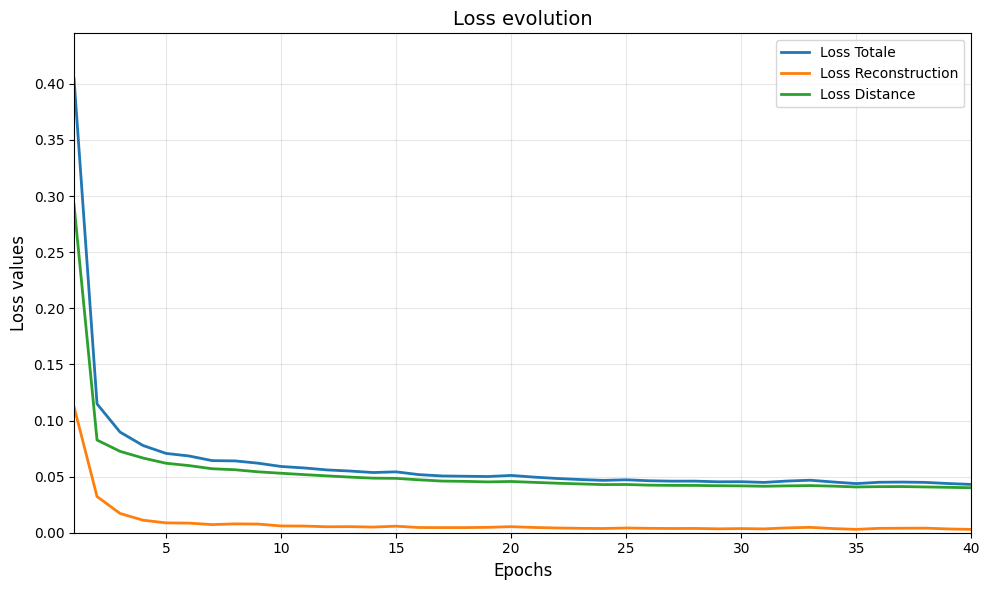

In [55]:
CONV=True
INPUT_DIM = signals_tensor.shape[1]
LATENT_DIM = 256
EPOCHS = 40
LEARNING_RATE = 0.001

ecg_autoencoder = AutoEncoder(input_dim=INPUT_DIM, latent_dim=LATENT_DIM, conv=CONV)
total_loss, reconstruction_loss, distance_loss = train(autoencoder=ecg_autoencoder, train_loader=train_dataloader, params_train=params_tensor, epochs=EPOCHS, verbose=True)

plot_loss(total_loss, reconstruction_loss, distance_loss)

## 7.3 ECG parameter trajectory in latent space

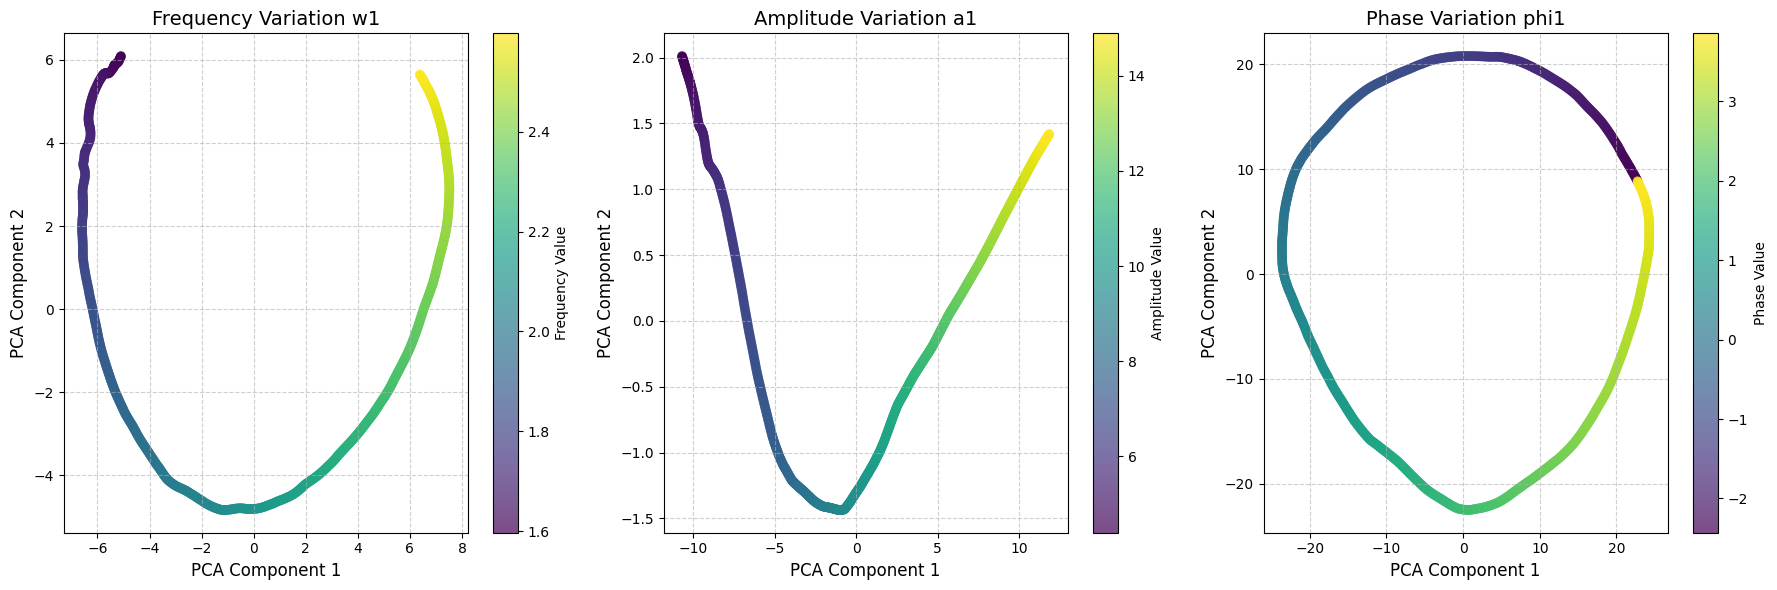

In [56]:
plot_ecg_latent_space_variations(autoencoder, full_dataset)

## 7.4 ECG signals distance measurement

Latent vectors encoder: 100%|██████████| 30432/30432 [00:24<00:00, 1220.97it/s]


Closest pair: (6759, 6785), Distance: 0.1956
Farthest pair: (4038, 20243), Distance: 3.9049
Random pair: [23343 23236], Distance: 2.0439


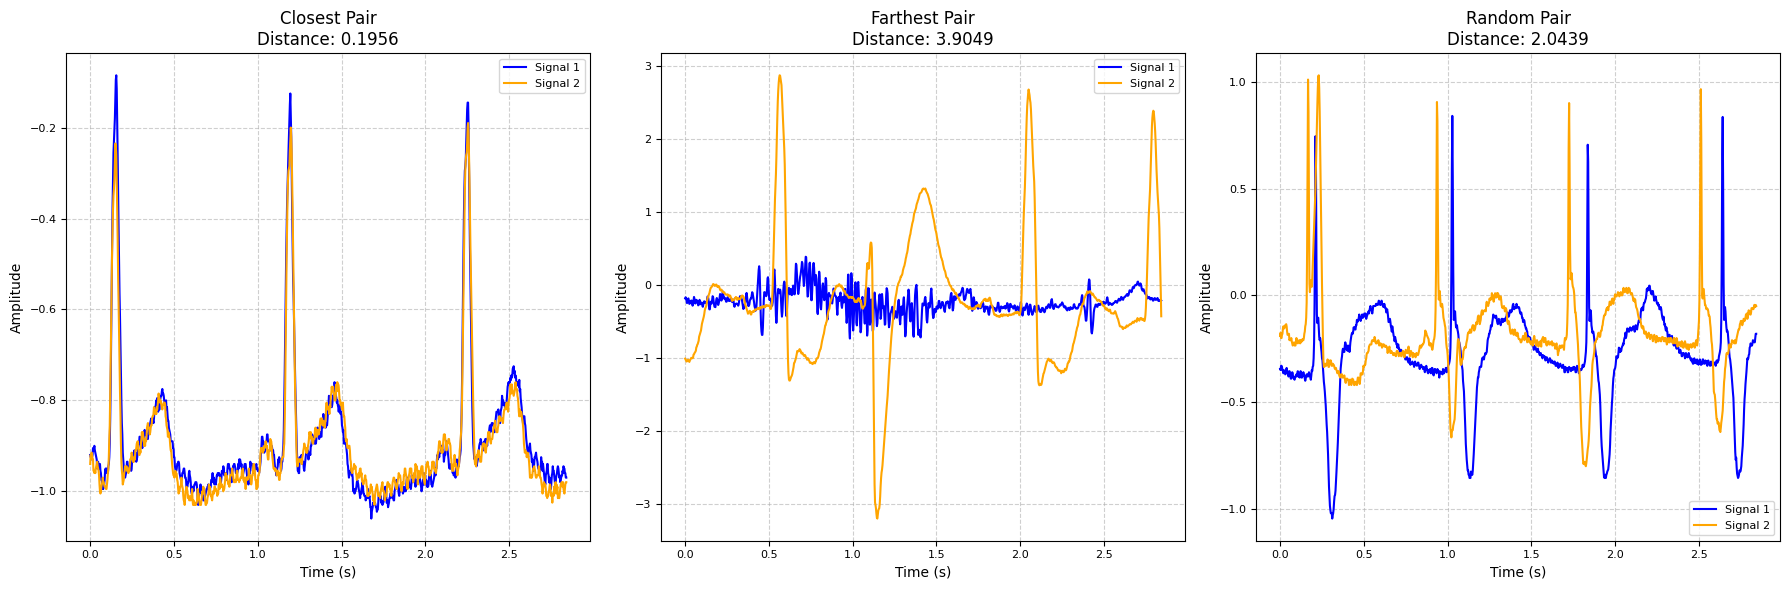

In [62]:
ecg_latent_vectors = compute_latent_vectors(ecg_dataset, ecg_autoencoder)
ecg_latent_vectors_tensor = torch.tensor(ecg_latent_vectors, dtype=torch.float32)

distances = compute_vector_distances(ecg_latent_vectors_tensor)

closest_pair_indices, farthest_pair_indices, closest_distance, farthest_distance = find_closest_and_farthest_pairs(distances)

random_indices = np.random.choice(len(signals), 2, replace=False)
random_distance = distances[random_indices[0], random_indices[1]].item()

print(f"Closest pair: {closest_pair_indices}, Distance: {closest_distance:.4f}")
print(f"Farthest pair: {farthest_pair_indices}, Distance: {farthest_distance:.4f}")
print(f"Random pair: {random_indices}, Distance: {random_distance:.4f}")

closest_signals = [signals[closest_pair_indices[0]], signals[closest_pair_indices[1]]]
farthest_signals = [signals[farthest_pair_indices[0]], signals[farthest_pair_indices[1]]]
random_signals = [signals[random_indices[0]], signals[random_indices[1]]]

time_axis = np.linspace(0, len(signals[0]) / record.fs, len(signals[0]), endpoint=False)

plot_signals(
    signals=[closest_signals, farthest_signals, random_signals],
    titles=["Closest Pair", "Farthest Pair", "Random Pair"],
    colors=[["blue", "orange"], ["blue", "orange"], ["blue", "orange"]],
    distances=[closest_distance, farthest_distance, random_distance],
    time_axis=time_axis
)


## 7.5 ECG signals auto-encoder reconstruction

/tmp/ipykernel_25049/2245504803.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipykernel_25049/2245504803.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


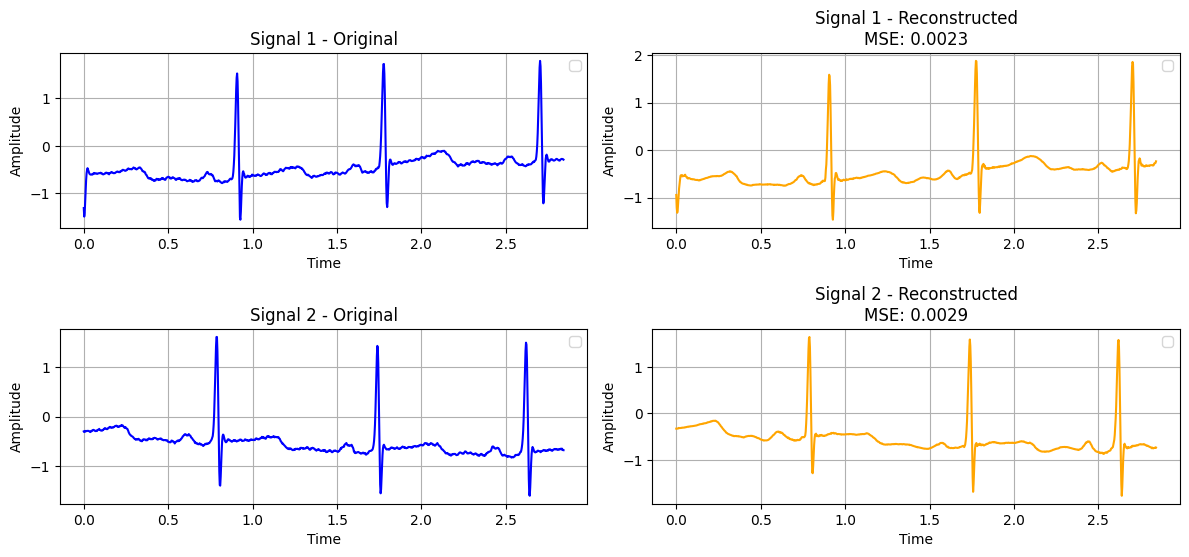

In [60]:
ecg_signals = np.array([item[0] for item in ecg_dataset[:100]])
time = np.linspace(0, len(ecg_signals[0]) / record.fs, len(ecg_signals[0]), endpoint=False)

reconstructed_signals = compute_reconstructed_signals(ecg_dataset, ecg_autoencoder)

mse_errors = [mean_squared_error(ecg_signals[i], reconstructed_signals[i]) for i in range(len(ecg_signals))]

plt.figure(figsize=(12, 8))

for i in range(2):

    plt.subplot(3, 2, 2 * i + 1)
    plt.plot(time, ecg_signals[i + 8],color="blue")
    plt.title(f"Signal {i + 1} - Original")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)

    plt.subplot(3, 2, 2 * i + 2)
    plt.plot(time, reconstructed_signals[i + 8],color="orange")
    plt.title(f"Signal {i + 1} - Reconstructed\nMSE: {mse_errors[i + 8]:.4f}")  
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## PCA cumulative explained variance

Latent vectors encoder: 100%|██████████| 30432/30432 [00:24<00:00, 1233.80it/s]


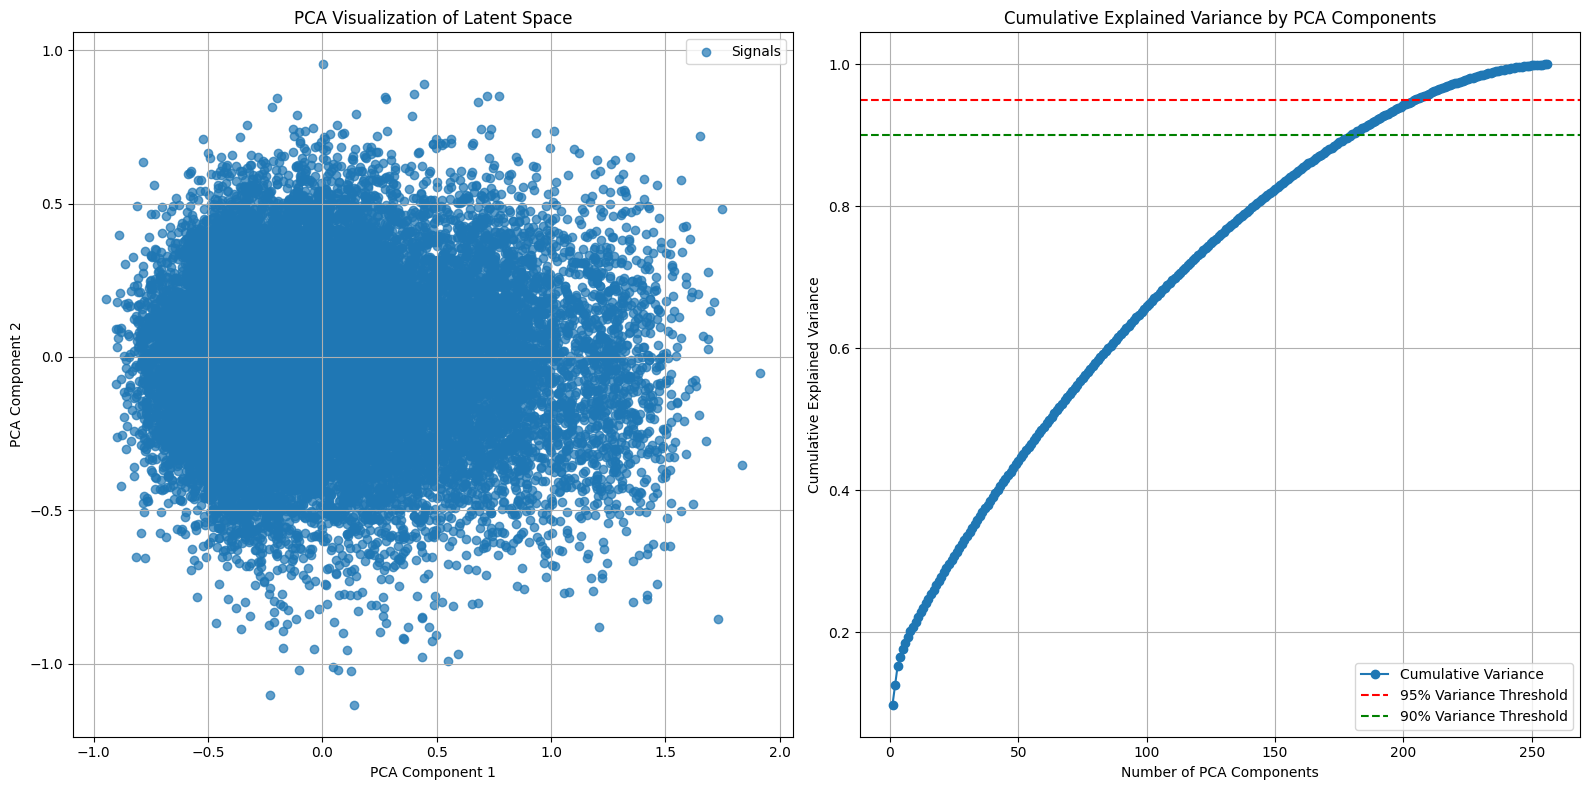

In [61]:
ecg_latent_vectors = compute_latent_vectors(ecg_dataset, ecg_autoencoder)
plot_pca(ecg_latent_vectors)